In [1]:
import keras
from keras.datasets import mnist
from keras.models import load_model

from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import deeplift
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import get_integrated_gradients_function


Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36_deeplift/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/tensorflow_p36_deeplift/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/tensorflow_p36_deeplift/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dt

In [2]:
#Load MNIST data

dataset_name = "mnist_3_vs_5"

img_rows, img_cols = 28, 28

num_classes = 10
batch_size = 32

included_classes = { 3, 5 }

(x_train, y_train), (x_test, y_test) = mnist.load_data()

keep_index_train = []
for i in range(y_train.shape[0]) :
    if y_train[i] in included_classes :
        keep_index_train.append(i)

keep_index_test = []
for i in range(y_test.shape[0]) :
    if y_test[i] in included_classes :
        keep_index_test.append(i)

x_train = x_train[keep_index_train]
x_test = x_test[keep_index_test]
y_train = y_train[keep_index_train]
y_test = y_test[keep_index_test]

n_train = int((x_train.shape[0] // batch_size) * batch_size)
n_test = int((x_test.shape[0] // batch_size) * batch_size)
x_train = x_train[:n_train]
x_test = x_test[:n_test]
y_train = y_train[:n_train]
y_test = y_test[:n_test]


x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print("x_train.shape = " + str(x_train.shape))

print("n train samples = " + str(x_train.shape[0]))
print("n test samples = " + str(x_test.shape[0]))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#Binarize images

def _binarize_images(x, val_thresh=0.5) :
    
    x_bin = np.zeros(x.shape)
    x_bin[x >= val_thresh] = 1.
    
    return x_bin

x_train = _binarize_images(x_train, val_thresh=0.5)
x_test = _binarize_images(x_test, val_thresh=0.5)


x_train.shape = (11552, 28, 28, 1)
n train samples = 11552
n test samples = 1888


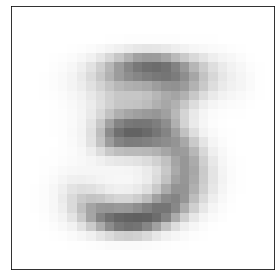

In [3]:
#Visualize background image distribution

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 3)) + pseudo_count) / (x_train.shape[0] + pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))

f = plt.figure(figsize=(4, 4))

plot_ix = 0

plt.imshow(x_mean, cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()
plt.show()


In [4]:
#Tile the ref background to same shape as test set

x_mean_tiled_test = np.tile(np.expand_dims(np.expand_dims(x_mean, axis=0), axis=-1), (x_test.shape[0], 1, 1, 1))


In [5]:
#Specify deeplift attribution models

gradient_model = kc.convert_model_from_saved_files(
    "saved_models/mnist_binarized_cnn_10_digits.h5",
    nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.Gradient
)
gradient_func = gradient_model.get_target_multipliers_func(find_scores_layer_idx=0, target_layer_idx=-2)

guided_backprop_model = kc.convert_model_from_saved_files(
    "saved_models/mnist_binarized_cnn_10_digits.h5",
    nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.GuidedBackprop
)
guided_backprop_func = guided_backprop_model.get_target_multipliers_func(find_scores_layer_idx=0, target_layer_idx=-2)

rescale_model = kc.convert_model_from_saved_files(
    "saved_models/mnist_binarized_cnn_10_digits.h5",
    nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.Rescale
)
rescale_func = rescale_model.get_target_multipliers_func(find_scores_layer_idx=0, target_layer_idx=-2)

revealcancel_model = kc.convert_model_from_saved_files(
    "saved_models/mnist_binarized_cnn_10_digits.h5",
    nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.RevealCancel
)
revealcancel_func = revealcancel_model.get_target_multipliers_func(find_scores_layer_idx=0, target_layer_idx=-2)

integrated_gradients_func = get_integrated_gradients_function(gradient_func, 10)

attribution_suffixes = [
    'gradient',
    'guided_backprop',
    'rescale',
    'revealcancel',
    'integrated_gradients'
]

attribution_funcs = [
    gradient_func,
    guided_backprop_func,
    rescale_func,
    revealcancel_func,
    integrated_gradients_func
]


nonlinear_mxts_mode is set to: Gradient


/home/ubuntu/anaconda3/envs/tensorflow_p36_deeplift/lib/python3.6/site-packages/deeplift/conversion/kerasapi_conversion.py:352: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  str_data = h5py.File(h5_file).attrs["model_config"]
/home/ubuntu/anaconda3/envs/tensorflow_p36_deeplift/lib/python3.6/site-packages/deeplift/conversion/kerasapi_conversion.py:359: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs f

Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
TARGET LAYER SET TO preact_7
nonlinear_mxts_mode is set to: GuidedBackprop
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
TARGET LAYER SET TO preact_7
nonlinear_mxts_mode is set to: Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
TARGET LAYER SET TO preact_7
nonlinear_mx

Attribution method = 'gradient'
Done 0
Done 0
Test image 0:


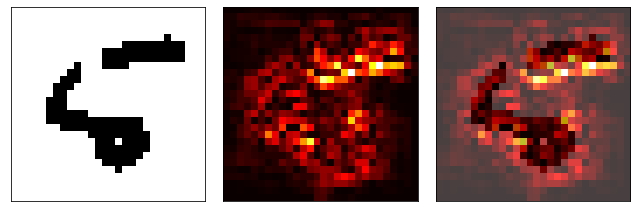

Test image 1:


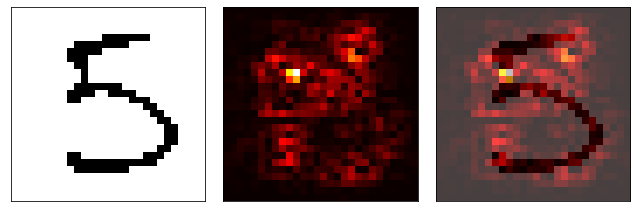

Test image 2:


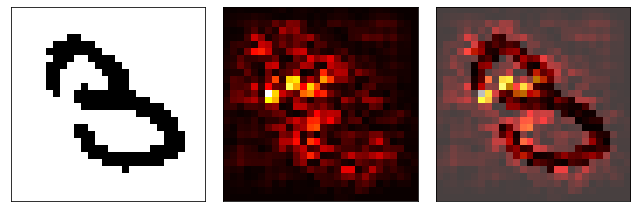

Test image 3:


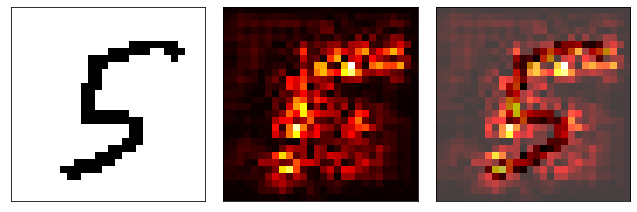

Test image 4:


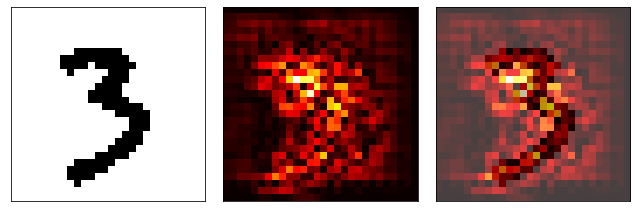

Test image 5:


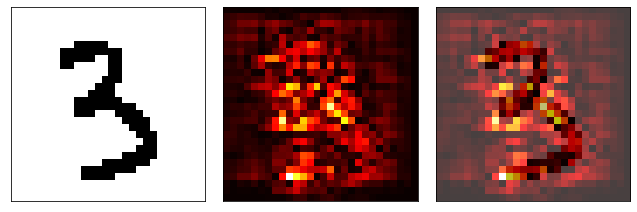

Test image 6:


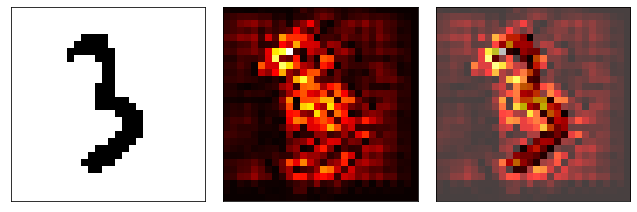

Test image 7:


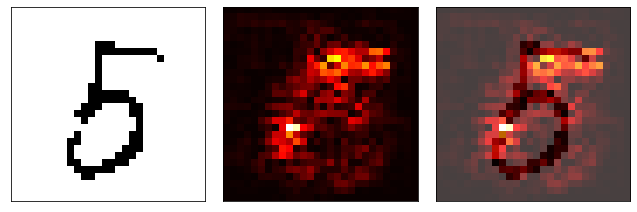

Test image 8:


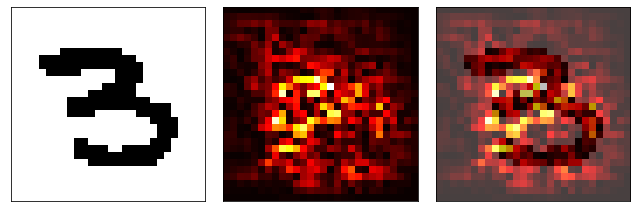

Test image 9:


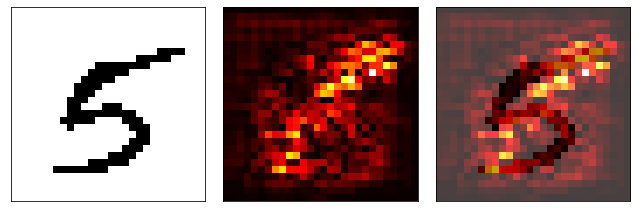

Attribution method = 'guided_backprop'
Done 0
Done 0
Test image 0:


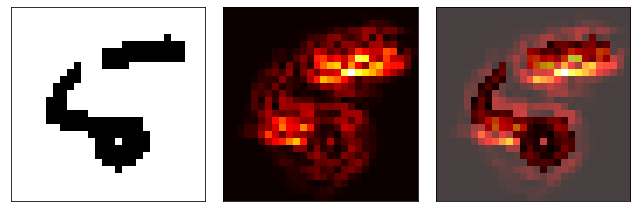

Test image 1:


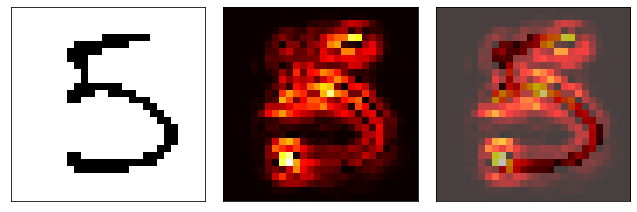

Test image 2:


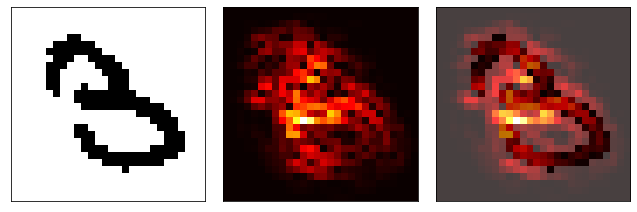

Test image 3:


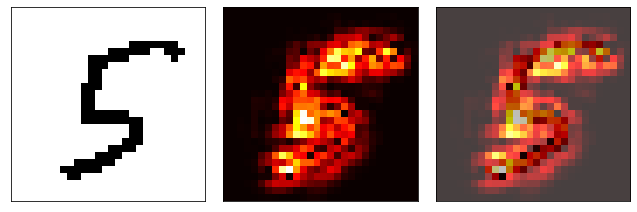

Test image 4:


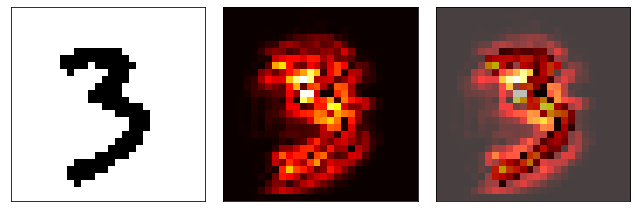

Test image 5:


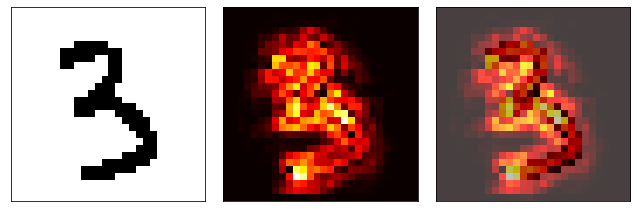

Test image 6:


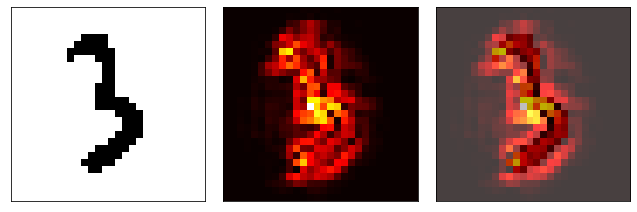

Test image 7:


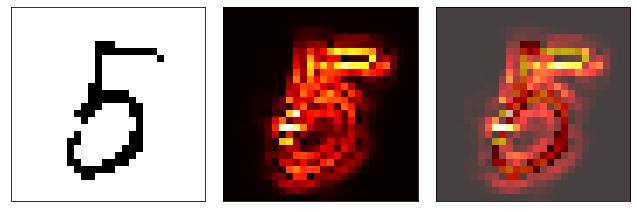

Test image 8:


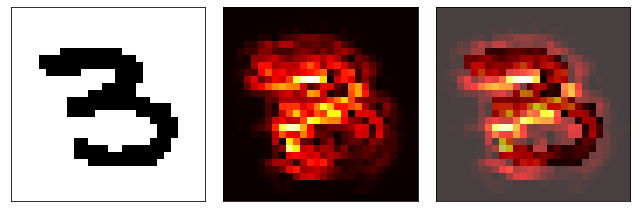

Test image 9:


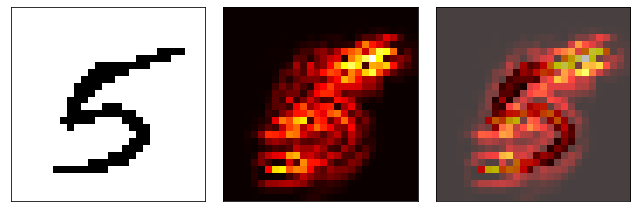

Attribution method = 'rescale'
Done 0
Done 0
Test image 0:


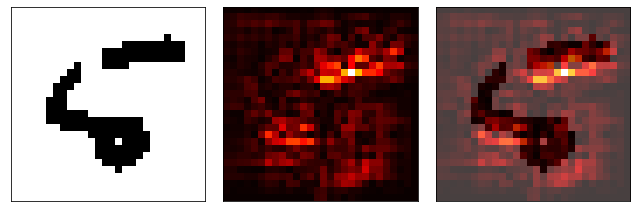

Test image 1:


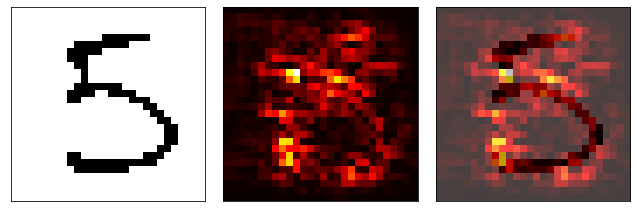

Test image 2:


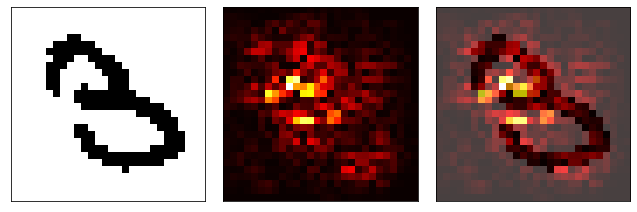

Test image 3:


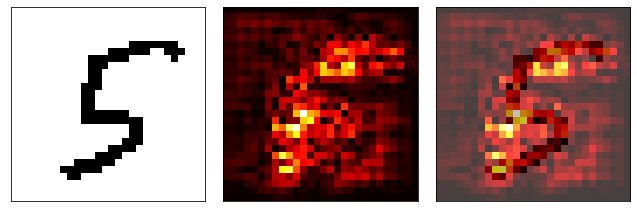

Test image 4:


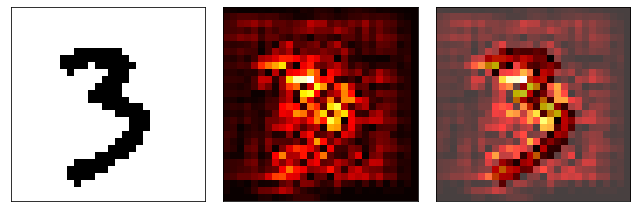

Test image 5:


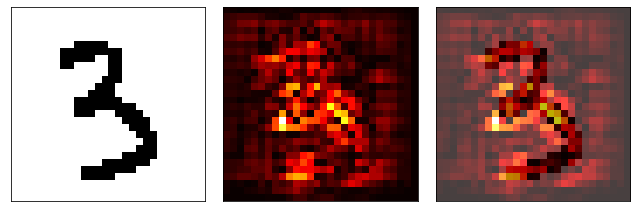

Test image 6:


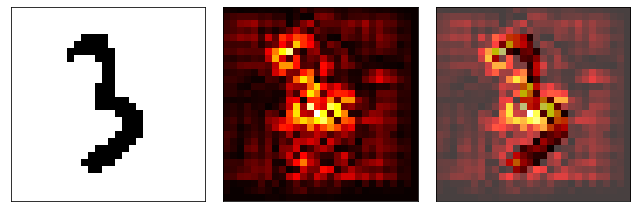

Test image 7:


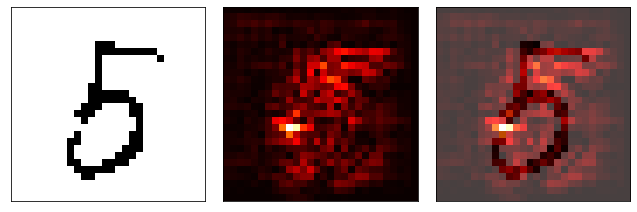

Test image 8:


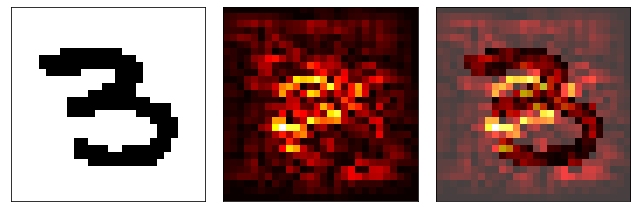

Test image 9:


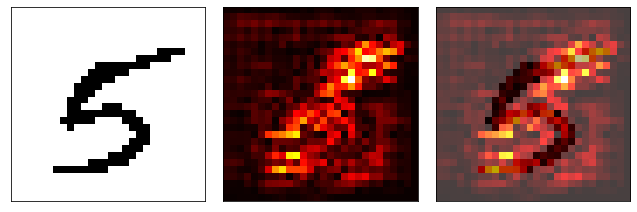

Attribution method = 'revealcancel'
Done 0
Done 0
Test image 0:


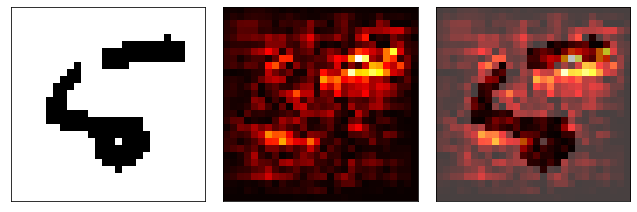

Test image 1:


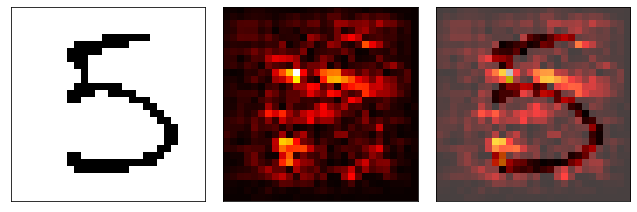

Test image 2:


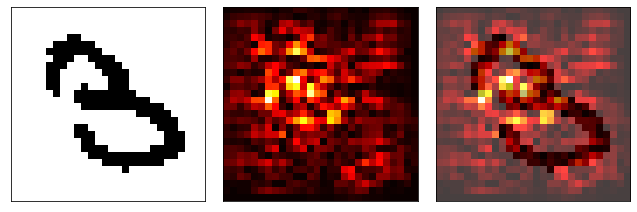

Test image 3:


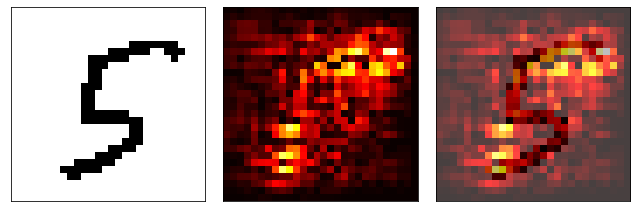

Test image 4:


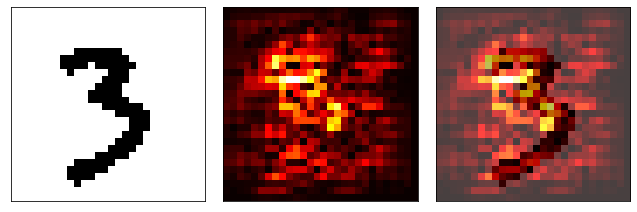

Test image 5:


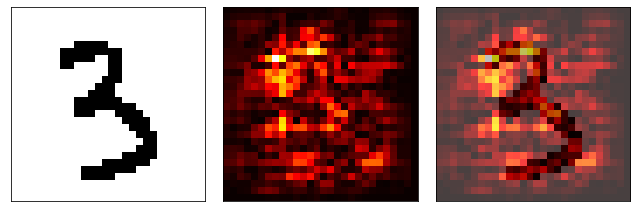

Test image 6:


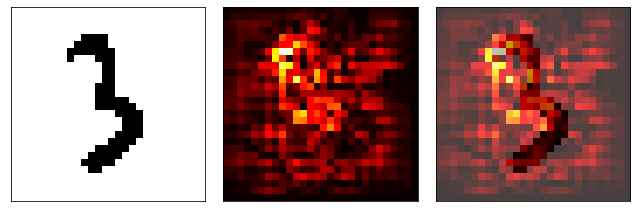

Test image 7:


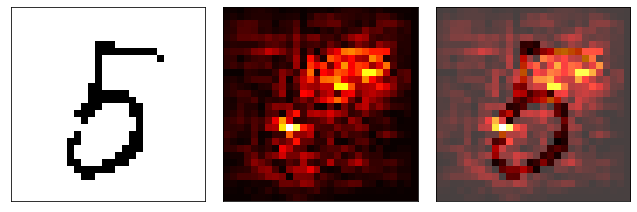

Test image 8:


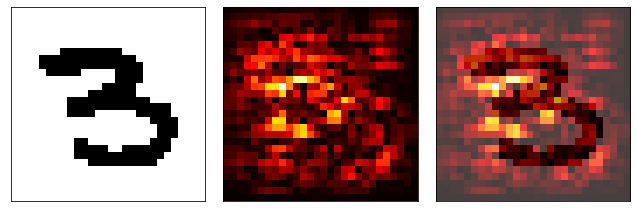

Test image 9:


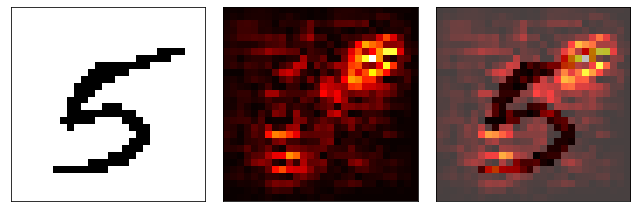

Attribution method = 'integrated_gradients'
Done 0
Done 4000
Done 8000
Done 12000
Done 16000
Done 0
Done 4000
Done 8000
Done 12000
Done 16000
Test image 0:


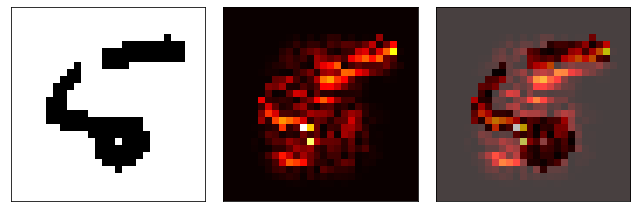

Test image 1:


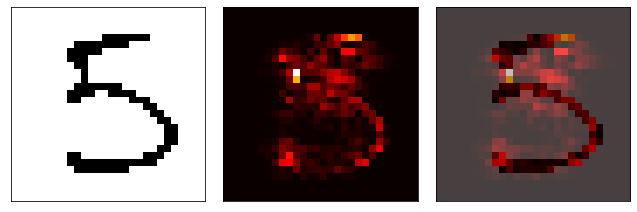

Test image 2:


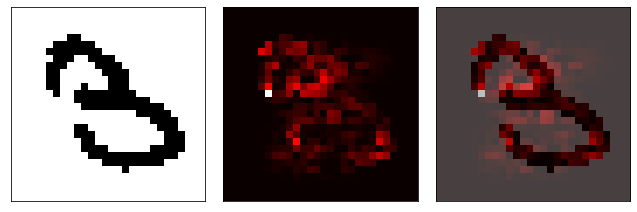

Test image 3:


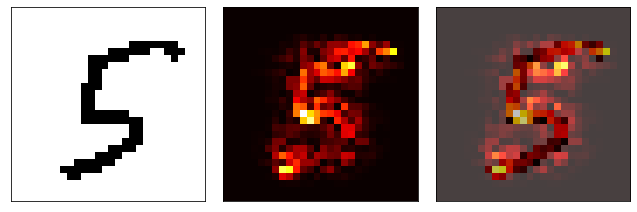

Test image 4:


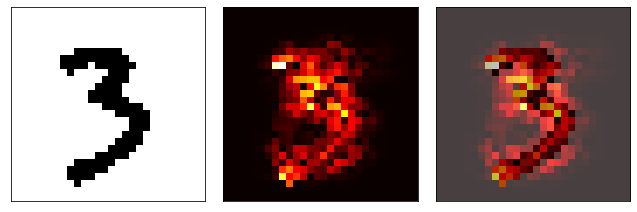

Test image 5:


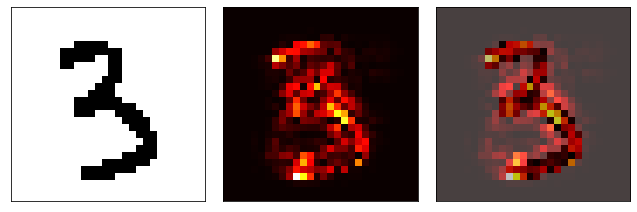

Test image 6:


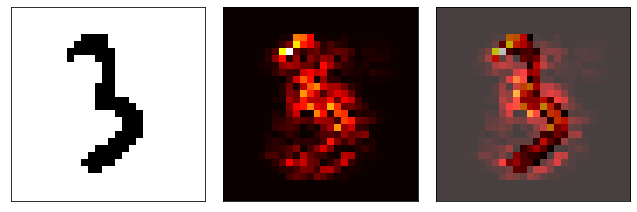

Test image 7:


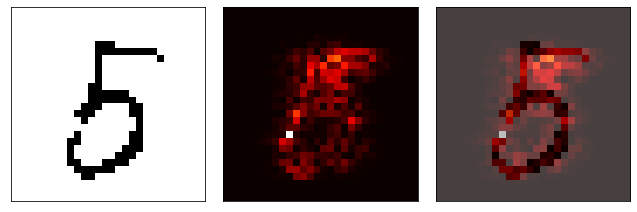

Test image 8:


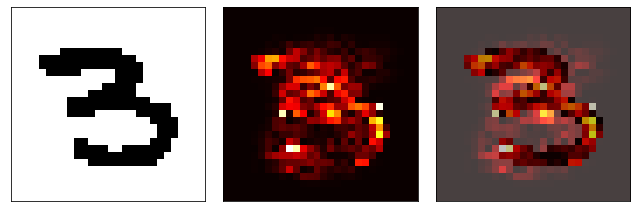

Test image 9:


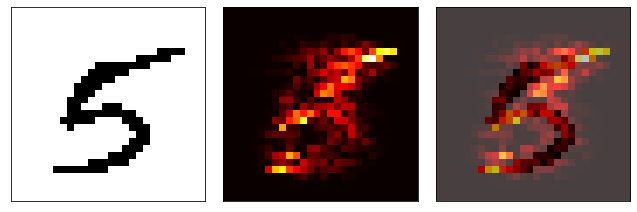

In [6]:
#Run attribution methods

digit_test = np.argmax(y_test, axis=1)

for attr_suffix, attr_func in zip(attribution_suffixes, attribution_funcs) :
    
    print("Attribution method = '" + attr_suffix + "'")

    importance_scores_test_3 = np.array(attr_func(task_idx=3, input_data_list=[x_test], input_references_list=[x_mean_tiled_test], batch_size=32, progress_update=1000))
    importance_scores_test_5 = np.array(attr_func(task_idx=5, input_data_list=[x_test], input_references_list=[x_mean_tiled_test], batch_size=32, progress_update=1000))

    importance_scores_test = np.zeros(importance_scores_test_3.shape)

    importance_scores_test[digit_test == 3, :, :, :] = importance_scores_test_3[digit_test == 3, :, :, :]
    importance_scores_test[digit_test == 5, :, :, :] = importance_scores_test_5[digit_test == 5, :, :, :]

    importance_scores_test = np.abs(importance_scores_test)

    #Visualize a few images

    for plot_i in range(0, 10) :

        print("Test image " + str(plot_i) + ":")

        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 3, 3))

        ax1.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

        plt.sca(ax1)
        plt.xticks([], [])
        plt.yticks([], [])

        ax2.imshow(importance_scores_test[plot_i, :, :, 0], cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

        plt.sca(ax2)
        plt.xticks([], [])
        plt.yticks([], [])

        ax3.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

        ax3.imshow(importance_scores_test[plot_i, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

        plt.sca(ax3)
        plt.xticks([], [])
        plt.yticks([], [])

        plt.tight_layout()
        plt.show()

    #Save predicted importance scores

    model_name = "deeplift_" + dataset_name + "_method_" + attr_suffix

    np.save(model_name + "_importance_scores_test", importance_scores_test)
